In [49]:
import pandas as pd
import re
import matplotlib.pyplot as plt


In [14]:
wine_df=pd.read_csv("../Resources/Winedata.csv")
wine_df.head()

,id,country,description,designation,points,price,province,region_1,region_2,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",VulkÃ Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Nicosia 2013 VulkÃ Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [6]:
weather_df=pd.read_csv("../Resources/weatherdata.csv")
weather_df.head()

,id,province,year,rainfall,temp,timeseries
0,100000,California,2010,1097.267553,11.935539,HISTORICAL
1,100001,Washington,2006,1317.200439,19.605871,HISTORICAL
2,100002,Bordeaux,2004,508.008118,17.847053,HISTORICAL
3,100003,Tuscany,2003,626.519243,12.979346,HISTORICAL
4,100004,Oregon,2006,1460.442217,10.609145,HISTORICAL


In [16]:
wine_df['Year']=wine_df['title'].str.extract(r'([1-2]\d{3})')
wine_df.pop('title')
wine_df.head()

,id,country,description,designation,points,price,province,region_1,region_2,variety,winery,Year
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",VulkÃ Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,White Blend,Nicosia,2013
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Portuguese Red,Quinta dos Avidagos,2011
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Pinot Gris,Rainstorm,2013
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Riesling,St. Julian,2013
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Sweet Cheeks,2012


In [17]:
wine_df.describe()

,id,points,price
count,129970.000000,129970.000000,120974.000000
mean,64984.528545,88.447095,35.363268
std,37519.299611,3.039703,41.022366
min,0.000000,80.000000,4.000000
25%,32492.250000,86.000000,17.000000
50%,64984.500000,88.000000,25.000000
75%,97476.750000,91.000000,42.000000
max,129970.000000,100.000000,3300.000000


In [22]:
wine_df['variety'].unique()

array(['White Blend', 'Portuguese Red', 'Pinot Gris', 'Riesling',
       'Pinot Noir', 'Tempranillo-Merlot', 'Frappato', 'GewÃ¼rztraminer',
       'Cabernet Sauvignon', 'Nerello Mascalese', 'Chardonnay', 'Malbec',
       'Tempranillo Blend', 'Meritage', 'Red Blend', 'Merlot',
       "Nero d'Avola", 'Chenin Blanc', 'Gamay', 'Sauvignon Blanc',
       'Viognier-Chardonnay', 'Primitivo', 'Catarratto', 'Inzolia',
       'Petit Verdot', 'Monica', 'Bordeaux-style White Blend', 'Grillo',
       'Sangiovese', 'Cabernet Franc', 'Portuguese White',
       'Champagne Blend', 'Bordeaux-style Red Blend', 'Aglianico',
       'Petite Sirah', 'Touriga Nacional', 'CarmenÃ¨re', 'AlbariÃ±o',
       'Petit Manseng', 'RosÃ©', 'Zinfandel', 'Vernaccia', 'Rosato',
       'GrÃ¼ner Veltliner', 'Viognier', 'Vermentino', 'Grenache Blanc',
       'Syrah', 'Nebbiolo', 'Shiraz-Cabernet Sauvignon', 'Pinot Blanc',
       'Alsace white blend', 'Barbera', 'RhÃ´ne-style Red Blend',
       'Graciano', 'Tannat-Cabernet', 'S

In [43]:
#filter wine_df for regions we want to examine
regions=['California','Washington','Bordeaux','Tuscany','Oregon','Burgundy','Cantabria','Piedmont','Veneto','New York','Alsace','Sicily & Sardinia','Champagne']
wine_df_regions=wine_df[wine_df['province'].isin(regions)]

In [44]:
wine_df_regions

,id,country,description,designation,points,price,province,region_1,region_2,variety,winery,Year
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",VulkÃ Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,White Blend,Nicosia,2013
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Pinot Gris,Rainstorm,2013
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Sweet Cheeks,2012
6,6,Italy,"Here''s a bright, informal red that opens with...",Belsito,87,16.0,Sicily & Sardinia,Vittoria,NaN,Frappato,Terre di Giurfo,2013
7,7,France,This dry and restrained wine offers spice in p...,NaN,87,24.0,Alsace,Alsace,NaN,GewÃ¼rztraminer,Trimbach,2012
...,...,...,...,...,...,...,...,...,...,...,...,...
129964,129965,France,"While it''s rich, this beautiful dry wine also...",Seppi Landmann VallÃ©e Noble,90,28.0,Alsace,Alsace,NaN,Pinot Gris,Domaine RieflÃ©-Landmann,2013
129966,129967,US,Citation is given as much as a decade of bottl...,NaN,90,75.0,Oregon,Oregon,Oregon Other,Pinot Noir,Citation,2004
129967,129968,France,Well-drained gravel soil gives this wine its c...,Kritt,90,30.0,Alsace,Alsace,NaN,GewÃ¼rztraminer,Domaine Gresser,2013
129968,129969,France,"A dry style of Pinot Gris, this is crisp with ...",NaN,90,32.0,Alsace,Alsace,NaN,Pinot Gris,Domaine Marcel Deiss,2012


In [47]:
variety_valuecounts=wine_df_regions['variety'].value_counts()
variety_valuecounts

Pinot Noir                  11643
Chardonnay                   9335
Cabernet Sauvignon           7368
Bordeaux-style Red Blend     6350
Red Blend                    6016
                            ...  
Vespaiolo                       1
Abouriou                        1
Syrah-Merlot                    1
Garnacha Blanca                 1
Alvarinho                       1
Name: variety, Length: 318, dtype: int64

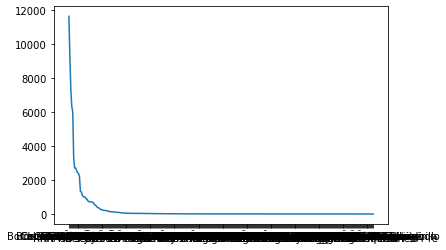

In [52]:
fix, ax=plt.subplots()
ax.plot(variety_valuecounts)